In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 10599
aqua_globals.random_seed = seed

import sys
import os
from pathlib import Path
import pickle
import numpy as np
import time
import sklearn.model_selection as model_selection
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
main_folder=str(Path.cwd().parent) 
sys.path.append(main_folder) 
data_folder = f'{main_folder}/data'


<ipython-input-1-c8eaf05e51af>:11: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  aqua_globals.random_seed = seed


# TO-DO:

- Improve the accuracy via Feature Engineer or Hyperparam
- Try with 3 classes (STAR, GALAXY , QSOR)
- Try with more data (currently training is 100 and test is 40 and test extra is 20)

## Loading the processed data DR16_Processed

In [2]:
#Load the data from pickle file

with open(f'{data_folder}/processed/DR16_processed_X.pkl','rb') as input_file:
    X = pickle.load(input_file)
with open(f'{data_folder}/processed/DR16_processed_y.pkl','rb') as input_file:
    y = pickle.load(input_file)

# You can also load the csv file but bewared of the datatype   
# X = pd.read_csv(f'{data_folder}/processed/DR16_processed_X.csv')
# y = pd.read_csv(f'{data_folder}/processed/DR16_processed_y.csv')

In [3]:
# Create binary target for 1st trial
y_star = y.apply(lambda x: "STAR" if x == "STAR" else "NOT_STAR")
class_labels_Star = list(set(y_star))
y_star_num =  y_star.apply(lambda x: 1 if x == "STAR" else 0)

In [4]:
#Create training_dataset and test_dataset with STAR and NOT_STAR
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_star_num, train_size=0.001, test_size=0.999, random_state=101)

# Create 1st test data
X_test_40 = X_test.iloc[:100].copy()
y_test_40 = y_test.iloc[:100].copy()

# 2nd test data 
X_test_extra = X_test.iloc[101:201].copy()
y_test_extra = y_test.iloc[101:201].copy()

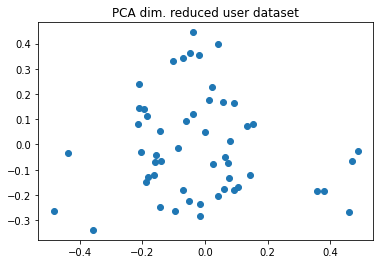

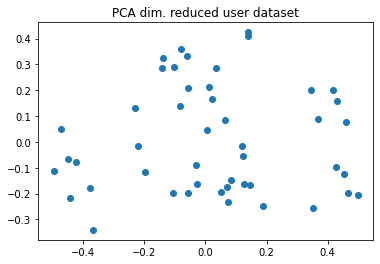

In [5]:
# Now reduce number of features to number of qubits
pca = PCA(n_components=2).fit(X_train)
X_train = pca.transform(X_train)
X_test_40 = pca.transform(X_test_40)
X_test_extra = pca.transform(X_test_extra)

# Create datapoint[X_test,y]
datapoints = [np.array(X_test_extra),np.array(y_test_extra)]
# If class labels are numeric
training_size = len(X_train)
test_size = len(X_test_40)
test_size_extra = len(X_test_extra)

#this is where I transform our dataframe to Dict[key:np.array]
if class_labels_Star[0].isdigit():
        # Pick training size number of samples from each distro
    training_input = {key: (X_train[y_train == int(key), :])[:training_size] for k, key in enumerate(class_labels_Star)}
    #test_input_extra = {key: (X_test_extra[y_test_extra == int(key), :])[:test_size_extra] for k, key in enumerate(class_labels_Star)}
    test_input = {key: (X_test_40[y_test == int(key), :])[: test_size] for k, key in enumerate(class_labels_Star)}
else:
    # if they aren't
    training_input = {key: (X_train[y_train == k, :])[:training_size] for k, key in enumerate(class_labels_Star)}
    #test_input_extra = {key: (X_test_extra[y_test_extra == k, :])[:test_size_extra] for k, key in enumerate(class_labels_Star)}
    test_input = {key: (X_test_40[y_test_40 == k, :])[:test_size] for k, key in enumerate(class_labels_Star)}

# Plot the 2 dimension result of PCA to check for correlation 
for k in range(0, 2):
    plt.scatter(X_train[y_train == k, 0][:training_size],
    X_train[y_train == k, 1][:training_size])
       
    plt.title("PCA dim. reduced user dataset")
    plt.show()   

With the dataset ready we can setup the [QSVM](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.QSVM.html) algorithm to do a classification. Here we use the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) data encoding circuit from the Qiskit circuit library.

Here the BasicAer `qasm_simulator` is used with 1024 shots.

For the testing, the result includes the details and the success ratio. For the prediction, the result includes the predicted labels. 

 QSVM
 """
        Args:
            feature_map: Feature map module, used to transform data
            training_dataset: Training dataset.
            test_dataset: Testing dataset.
            datapoints: Prediction dataset.
            multiclass_extension: If number of classes is greater than 2 then a multiclass scheme
                must be supplied, in the form of a multiclass extension.
            lambda2: L2 norm regularization factor
            quantum_instance: Quantum Instance or Backend

In [6]:
feature_dim = 2

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='full')
qsvm = QSVM(feature_map, training_input, test_input, datapoints[0])

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
start_run_qsvm = time.time()
result = qsvm.run(quantum_instance)
end_run_qsvm = time.time()
print(f'run time is: {end_run_qsvm - start_run_qsvm}')

print(f'Testing success ratio: {result["testing_accuracy"]}')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}')
print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
success_rate = 100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)
print(f'  success rate: {success_rate}%')

/Users/roro/Documents/QLearning/Quantstellar-QiskitHackathon21/QUANTSTELLAR-QISKIT-HACKATHON-21/venv/lib/python3.8/site-packages/qiskit/aqua/algorithms/classifiers/qsvm/qsvm.py:102: DeprecationWarning: The package qiskit.aqua.algorithms.classifiers is deprecated. It was moved/refactored to qiskit_machine_learning.algorithms.classifiers (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.algorithms.classifiers',
/Users/roro/Documents/QLearning/Quantstellar-QiskitHackathon21/QUANTSTELLAR-QISKIT-HACKATHON-21/venv/lib/python3.8/site-packages/qiskit/aqua/quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',
run time is

Qiskit also has a classical SVM implementation that takes the same input data for classification. Let's run this and do a comparison. Now the ad hoc data set was created to show that there can be datasets where quantum could give an advantage.

In [7]:
# from qiskit.aqua.algorithms import SklearnSVM

# result = SklearnSVM(training_input, test_input, [0]).run()
# kernel_matrix = result['kernel_matrix_training']
# plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r');


# print(f'Testing success ratio: {result["testing_accuracy"]}')
# print()
# print('Prediction from datapoints set:')
# print(f'  ground truth: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}')
# print(f'  prediction:   {result["predicted_classes"]}')
# predicted_labels = result["predicted_labels"]
# print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')

# kernel_matrix = result['kernel_matrix_training']
# plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r');

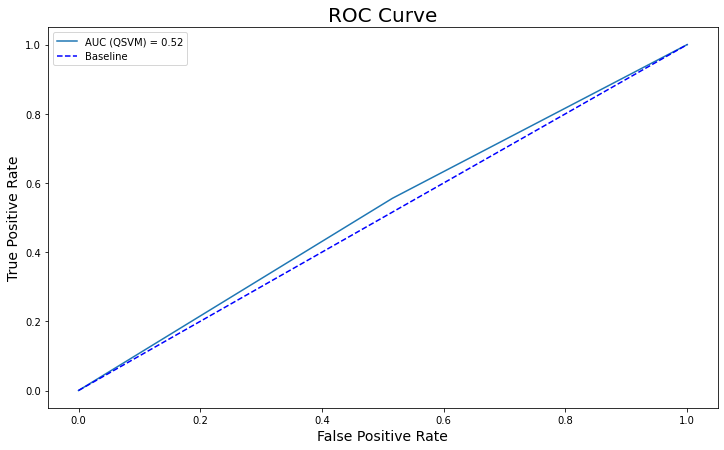

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve

# auc_svm = roc_auc_score(datapoints[1], predicted_labels)
# fpr_svm, tpr_svm, thresholds_svm = roc_curve(datapoints[1], predicted_labels)

auc_qsvm = roc_auc_score(datapoints[1], predicted_labels)
fpr_qsvm, tpr_qsvm, thresholds_qsvm = roc_curve(datapoints[1], predicted_labels)


plt.figure(figsize=(12, 7))
#plt.plot(fpr_svm, tpr_svm, label=f'AUC (Classical_SVM) = {auc_svm:.2f}')
plt.plot(fpr_qsvm, tpr_qsvm, label=f'AUC (QSVM) = {auc_qsvm:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend();

In [9]:
# Save Result
run = 2
result_dict = {
    'run':run,
    'algos': 'qsvm',
    'feature_map':'ZZFeaturemap',
    'feature_map_entangle':'full',
    'feature_reduction':'PCA',
     'feature_map_rep':'2',
    'feature_map_object': feature_map,
    'feature_dim': feature_dim,
    'No_Class' : len(class_labels_Star),
    'training size':len(X_train),
    'test size':len(X_test_40),
    'pred size':len(X_test_extra),
    'result_testing_accuracy':result["testing_accuracy"],
    'result_testing_accuracy':success_rate,
    'auc': auc_qsvm,
    'false_positive_rate':fpr_qsvm,
    'True_positive_rate':tpr_qsvm,
    'Threshold' : thresholds_qsvm
    }


In [10]:
with open(f'{main_folder}/models/model_{run}.pkl','wb') as output_file:
    pickle.dump(result_dict,output_file)